In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import numpy as np
import matplotlib.pylab as plt
from classy import Class
import sys,os
from scipy import interpolate as ip
from scipy import integrate

In [2]:
HOMEDIR = (os.path.expanduser('~'))+'/Dropbox/pk_fisher'
bias_terms = np.loadtxt('./bias_terms.txt')
pb22_ip = ip.interp1d(bias_terms[:,0],bias_terms[:,1])
pb2delta_ip = ip.interp1d(bias_terms[:,0],bias_terms[:,2])
pb2theta_ip = ip.interp1d(bias_terms[:,0],bias_terms[:,3])

In [3]:
# fiducial parameters
obh2_fid = 0.02225
och2_fid = 0.1198
theta_fid = 1.04077
lnAs_fid = 3.094
As_fid = np.exp(lnAs_fid)*1e-10
ns_fid = 0.9645
mnu_fid = 0.06
h0_fid = 0.6703234
om0_fid = (obh2_fid+och2_fid+mnu_fid/93.14)/h0_fid**2
ode0_fid = 1.0-om0_fid
b2_fid = 0.0
sigma_fid = 1.0
w_fid = -1.0

zmax = 5.0
kmin = 1e-2
kmax = 0.5

In [4]:
cosmo_fid = Class()
pars_fid = {'100*theta_s':theta_fid,'omega_b':obh2_fid,'omega_cdm':och2_fid,\
              'A_s':As_fid,'n_s':ns_fid,'m_ncdm':mnu_fid/3.,\
              'P_k_max_h/Mpc':kmax,'z_max_pk':zmax,\
              'output':'mPk','N_ur':0.00641,'N_ncdm':1,\
              'T_ncdm':0.71611,'deg_ncdm':3.}
cosmo_fid.set(pars_fid)
cosmo_fid.compute()

kh_arr = np.logspace(np.log10(kmin),np.log10(kmax),1000)
nk = 19
del_k = 0.01
kh_out = np.array([0.02+i*del_k for i in range(0,nk)])
kh_out_02 = np.tile(kh_out,2)

# Functions

In [5]:
# Legendre polynomical
def Leg(l,mu):
    if l == 0:
        return 1.
    elif l == 2:
        return 0.5*(3.0*mu**2-1.0) 
    else:
        print('l should be 0 or 2!')
        return None

In [6]:
def calc_pkmu(mu,k,b1,b2,sigma,As,alp_per,alp_para,rd_ratio,growth_ip,mpk0,mpkz):
    F = alp_para/alp_per
    fac = 1.0/alp_per**2/alp_para*rd_ratio**3
    r_kp = 1.0
    
    kp = k/alp_per*(1.0+mu**2*(1.0/F**2-1.0))**0.5
    mup = mu/F*(1.0+mu**2*(1.0/F**2-1.0))**(-0.5)
    
    growth_kp = growth_ip(kp)
    As_fid_pb = np.exp(3.094)*1e-10
    pb_norm = (As/As_fid_pb)**2.0*(mpkz(kp)/mpk0(kp))
    pb22 = pb22_ip(kp)*pb_norm**2
    pb2delta = pb2delta_ip(kp)*pb_norm**2
    pb2theta = pb2theta_ip(kp)*pb_norm**2

    mpk = mpkz(kp)
    Pgg = b1**2*mpk+2*b2*b1*pb2delta+b2**2*pb22
    Pgm = b1*r_kp*mpk+b2*pb2theta
    
    pkmu = (Pgg+2.0*growth_kp*mup**2.0*Pgm+growth_kp**2.0*mup**4.0*mpk) \
          *np.exp(-(growth_kp*kp*mup*sigma)**2) \
          *fac
    return pkmu

def calc_pk02(k,ell,pars):
    ans, tmp = integrate.quad(lambda mu: calc_pkmu(mu,k,*pars)*Leg(ell,mu),0.0,1.0)
    ans = 2*ans*(2*ell+1)/2.
    return ans

In [7]:
def calc_pkmu_deriv_bias(mu,k,b1,b2,sigma,As,alp_per,alp_para,rd_ratio,growth_ip,mpk0,mpkz,key):
    F = alp_para/alp_per
    fac = 1.0/alp_per**2/alp_para*rd_ratio**3
    r_kp = 1.0
    
    kp = k/alp_per*(1.0+mu**2*(1.0/F**2-1.0))**0.5
    mup = mu/F*(1.0+mu**2*(1.0/F**2-1.0))**(-0.5)
    
    growth_kp = growth_ip(kp)
    pb_norm = (As/As_fid)**2.0*(mpkz(kp)/mpk0(kp))
    pb22 = pb22_ip(kp)*pb_norm**2
    pb2delta = pb2delta_ip(kp)*pb_norm**2
    pb2theta = pb2theta_ip(kp)*pb_norm**2

    mpk = mpkz(kp)
    if key == 'b1':
        Pgg = 2*b1*mpk+2*b2*pb2delta
        Pgm = r_kp*mpk
        pkmu_deriv = (Pgg+2.0*growth_kp*mup**2.0*Pgm) \
              *np.exp(-(growth_kp*kp*mup*sigma)**2) \
              *fac        
    elif key == 'b2':
        Pgg = 2*b1*pb2delta+2*b2*pb22
        Pgm = pb2theta
        pkmu_deriv = (Pgg+2.0*growth_kp*mup**2.0*Pgm) \
              *np.exp(-(growth_kp*kp*mup*sigma)**2) \
              *fac
    elif key == 'sigma':
        Pgg = b1**2*mpk+2*b2*b1*pb2delta+b2**2*pb22
        Pgm = b1*r_kp*mpk+b2*pb2theta
        pkmu_deriv = (Pgg+2.0*growth_kp*mup**2.0*Pgm+growth_kp**2.0*mup**4.0*mpk) \
              *np.exp(-(growth_kp*kp*mup*sigma)**2) \
              *(-2*(growth_kp*kp*mup)**2*sigma) \
              *fac
    else:
        print('key error')
        return None
    return pkmu_deriv

def calc_pk02_deriv_bias(k,ell,pars,key):
    ans, tmp = integrate.quad(lambda mu: calc_pkmu_deriv_bias(mu,k,*pars,key)*Leg(ell,mu),0.0,1.0)
    ans = 2*ans*(2*ell+1)/2.
    return ans

In [8]:
# set paramaeter array for pk calculation
def set_params_pk(z,cosmo,obh2,och2,theta,lnAs,ns,mnu,b1,b2,sigma):
    def calc_growth_and_mpk(z,cosmo):
        # growth rate
        h0 = cosmo.h()
        a = 1./(1+z)
        del_a = 0.01
        pk0 = np.array([cosmo.pk(k*h0,0.0)*h0**3 for k in kh_arr])
        pkz = np.array([cosmo.pk(k*h0,z)*h0**3 for k in kh_arr])
        pkz1 = np.array([cosmo.pk(k*h0,1./(a+del_a)-1)*h0**3 for k in kh_arr])
        pkz2 = np.array([cosmo.pk(k*h0,1./(a-del_a)-1)*h0**3 for k in kh_arr])
        Dz1 = np.sqrt(pkz1/pk0)
        Dz2 = np.sqrt(pkz2/pk0)
        Dz = np.sqrt(pkz/pk0)
        growth = (Dz1-Dz2)/(2*del_a)*(a/Dz)

        growth_ip = ip.interp1d(kh_arr,growth)
        mpk0_ip = ip.interp1d(kh_arr,pk0)
        mpkz_ip = ip.interp1d(kh_arr,pkz)

        return growth_ip, mpk0_ip, mpkz_ip
    
    def get_AP_params(z,cosmo,obh2,och2,mnu):
        w = -1
        h0 = cosmo.h()
        h0_fid = cosmo_fid.h()
        om0 = (och2+obh2+mnu/93.14)/h0**2
        ode0 = 1.0-om0
        
        # AP parameters
        rd_fid = cosmo_fid.get_current_derived_parameters(['rs_d'])['rs_d']
        da_fid = cosmo_fid.angular_distance(z)
        Hz_fid = h0_fid*np.sqrt(om0_fid*(1.+z)**3.0+ode0_fid*(1.+z)**(3.0+3.0*w))
        rd = cosmo.get_current_derived_parameters(['rs_d'])['rs_d']
        da = cosmo.angular_distance(z)
        Hz = h0*np.sqrt(om0*(1.+z)**3.0+ode0*(1+z)**(3.0+3.0*w))
        alp_per = (da/da_fid)*(rd_fid/rd)
        alp_para = (Hz_fid/Hz)*(rd_fid/rd)
        rd_ratio = rd_fid/rd
        return alp_per,alp_para,rd_ratio
    
    pars_cosmo = {'100*theta_s':theta,'omega_b':obh2,'omega_cdm':och2,\
              'A_s':np.exp(lnAs)*1e-10,'n_s':ns,'m_ncdm':mnu/3.,\
              'P_k_max_h/Mpc':kmax,'z_max_pk':zmax,\
              'output':'mPk','N_ur':0.00641,'N_ncdm':1,\
              'T_ncdm':0.71611,'deg_ncdm':3.}
    cosmo.set(pars_cosmo)
    cosmo.compute()
    growth_ip, mpk0_ip, mpkz_ip = calc_growth_and_mpk(z,cosmo)
    alp_per,alp_para,rd_ratio = get_AP_params(z,cosmo,obh2,och2,mnu)

    pars_pk = [b1,b2,sigma,np.exp(lnAs)*1e-10,alp_per,alp_para,rd_ratio,growth_ip,mpk0_ip,mpkz_ip]
    return pars_pk

In [9]:
# get pk derivative
def get_pk02_deriv_all(z,cosmo):
    w = -1
    b1_fid = 0.9+0.4*z
    nparams_cosmo = 6
    nparams = nparams_cosmo+3 # cosmo params + b1, b2, sigma
    pk_deriv = np.zeros((nk*2,nparams))
    pars_delta = np.array([0.001,0.0025,0.005,0.05,0.01,0.02]) # for cosmological params
    pars_fid = np.array([obh2_fid,och2_fid,theta_fid,lnAs_fid,ns_fid,mnu_fid])
    
    # derivative of cosmological parameters
    for i in range(nparams_cosmo):
        delta = np.zeros(nparams_cosmo)
        delta[i] = pars_delta[i]
        # fid+
        pars = pars_fid+delta
        pars_pk = set_params_pk(z,cosmo,*pars,b1_fid,b2_fid,sigma_fid)
        pk_plus = np.r_[np.array([calc_pk02(k,0,pars_pk) for k in kh_out]),
                    np.array([calc_pk02(k,2,pars_pk) for k in kh_out])]
        # fid-
        pars = pars_fid-delta
        pars_pk = set_params_pk(z,cosmo,*pars,b1_fid,b2_fid,sigma_fid)
        pk_minus = np.r_[np.array([calc_pk02(k,0,pars_pk) for k in kh_out]),
                    np.array([calc_pk02(k,2,pars_pk) for k in kh_out])]
        pk_deriv[:,i] = (pk_plus-pk_minus)/(2.*delta[i])
        
    # derivative of b1, b2 and sigma
    pars = pars_fid
    pars_pk = set_params_pk(z,cosmo,*pars,b1_fid,b2_fid,sigma_fid)
    pk_deriv[:,nparams_cosmo+0] = np.r_[np.array([calc_pk02_deriv_bias(k,0,pars_pk,'b1') for k in kh_out]),
                                        np.array([calc_pk02_deriv_bias(k,2,pars_pk,'b1') for k in kh_out])]
    pk_deriv[:,nparams_cosmo+1] = np.r_[np.array([calc_pk02_deriv_bias(k,0,pars_pk,'b2') for k in kh_out]),
                                        np.array([calc_pk02_deriv_bias(k,2,pars_pk,'b2') for k in kh_out])]
    pk_deriv[:,nparams_cosmo+2] = np.r_[np.array([calc_pk02_deriv_bias(k,0,pars_pk,'sigma') for k in kh_out]),
                                        np.array([calc_pk02_deriv_bias(k,2,pars_pk,'sigma') for k in kh_out])]
    return pk_deriv

In [24]:
def calc_cov(k,l1,l2,nbar,pars):
    def cov_integrant(mu,k,l1,l2,nbar,pars):
        ans = Leg(l1,mu)*Leg(l2,mu)
        ans = ans*(calc_pkmu(mu,k,*pars)+1./nbar)**2.
        return ans
    ans, tmp = integrate.quad(lambda mu: cov_integrant(mu,k,l1,l2,nbar,pars),0.0,1.0)
    ans = ans*(2*l1+1)*(2*l2+1)
    return ans

def get_cov(z,cosmo,nbar):
    b1_fid = 0.9+0.4*z
    pars_fid = [obh2_fid,och2_fid,theta_fid,lnAs_fid,ns_fid,mnu_fid]
    pars_pk = set_params_pk(z,cosmo,*pars_fid,b1_fid,b2_fid,sigma_fid)
    # calc cov
    cov = np.zeros((nk*2,nk*2))
    for i in range(nk):
        for il1 in [0,1]:
            for il2 in [0,1]:
                l1 = il1*2
                l2 = il2*2
                cov[i+nk*il1,i+nk*il2] = calc_cov(kh_out[i],l1,l2,nbar,pars_pk)
    return cov

In [18]:
def calc_fisher(z,cosmo,b1_fid,ngal,vol):
    def calc_fisher_ij(i,j,pk_deriv,inv_cov):
        pk_deriv_i = pk_deriv[:,i]*del_k**0.5*kh_out_02
        pk_deriv_j = pk_deriv[:,j]*del_k**0.5*kh_out_02
        ans = np.dot(pk_deriv_i,np.dot(inv_cov,pk_deriv_j))
        return np.sum(ans)

    nbar = ngal/vol
    # b1_fid = 0.9+0.4*z # PFS
    nparams_cosmo = 6
    nparams = nparams_cosmo+3 # cosmo params + b1, b2, sigma
    fisher = np.zeros((nparams,nparams))
    # covariance
    cov = get_cov(z,cosmo,nbar)
    inv_cov = np.linalg.inv(cov)
    # pk derivative
    pk_deriv = get_pk02_deriv_all(z,cosmo)
    for i in range(nparams):
        for j in range(nparams):
            fisher[i,j] = calc_fisher_ij(i,j,pk_deriv,inv_cov)
    fisher = fisher*vol/4./np.pi**2
    return fisher

# Calculation

In [21]:
# PFS
# nz = 7
# z_arr = np.array([0.7,0.9,1.1,1.3,1.5,1.8,2.2])
# b1_arr = np.array([0.9+0.4*z for z in z_arr])
# vol_arr = np.array([0.59,0.79,0.96,1.09,1.19,2.58,2.71])*1e9
# nbar_arr = np.array([1.9,6.0,5.8,7.8,5.5,3.1,2.7])*1e-4 #/2.
# ngal_arr = vol_arr*nbar_arr

nz = 5
z_arr = np.array([0.7,0.9,1.1,1.3,1.5])
b1_arr = np.array([1.21,1.33,1.45,1.57,1.70])
vol_arr = np.array([5.2,6.8,8.0,9.0,9.8])*1e9
nbar_arr = np.array([5.9,7.3,4.2,2.5,0.53])*1e-4
ngal_arr = vol_arr*nbar_arr

In [25]:
# for i in range(10):
#     comp = 0.1+0.1*i
#     fisher_iz = np.zeros((9,9,nz))
#     for iz in range(nz):
#         cosmo = Class()
#         fisher_iz[:,:,iz] = calc_fisher(z_arr[iz],cosmo,ngal_arr[iz]*comp,vol_arr[iz]*comp)
#         cosmo.struct_cleanup()
# #         np.savetxt(HOMEDIR+'/pfs/fisher_comp'+'{:0.2f}'.format(comp)+'_iz'+str(iz)+'_ngal0p5.txt',fisher_iz[:,:,iz])
#         np.savetxt(HOMEDIR+'/pfs/fisher_comp'+'{:0.2f}'.format(comp)+'_iz'+str(iz)+'.txt',fisher_iz[:,:,iz])
    
# DESI
for i in range(5):
    comp = 0.2+0.2*i
    fisher_iz = np.zeros((9,9,nz))
    for iz in range(nz):
        cosmo = Class()
        fisher_iz[:,:,iz] = calc_fisher(z_arr[iz],cosmo,b1_arr[iz],ngal_arr[iz]*comp,vol_arr[iz]*comp)
        cosmo.struct_cleanup()
        np.savetxt(HOMEDIR+'/desi/fisher_comp'+'{:0.2f}'.format(comp)+'_iz'+str(iz)+'.txt',fisher_iz[:,:,iz])

In [26]:
def fisher_merge(fisher_iz,nz):
    nparam = 6+3
    nparam_allz = 6+3*nz
    fisher_allz = np.zeros((nparam_allz,nparam_allz))
    for iz in range(nz):
        for ip1 in range(nparam):
            ip1p = ip1
            if ip1 > 5: ip1p = ip1+3*iz
            for ip2 in range(nparam):
                ip2p = ip2
                if ip2 > 5: ip2p = ip2+3*iz
                fisher_allz[ip1p,ip2p] += fisher_iz[ip1,ip2,iz]
    # insert sigma(tau)^-1 = 0.0
    indx_tau = 6
    fisher_allz = np.insert(np.insert(fisher_allz,indx_tau,0,axis=0),indx_tau,0,axis=1)
    return fisher_allz

# def fisher_merge(fisher_iz,nz):
#     nparam_allz = 6+nz
#     fisher_allz = np.zeros((nparam_allz,nparam_allz))
#     for iz in range(nz):
#         for ip1 in range(7):
#             ip1p = ip1
#             if ip1 > 5: ip1p = ip1+iz
#             for ip2 in range(7):
#                 ip2p = ip2
#                 if ip2 > 5: ip2p = ip2+iz
#                 fisher_allz[ip1p,ip2p] += fisher_iz[ip1,ip2,iz]
#     # insert sigma(tau)^-1 = 0.0
#     indx_tau = 6
#     fisher_allz = np.insert(np.insert(fisher_allz,indx_tau,0,axis=0),indx_tau,0,axis=1)
#     return fisher_allz

In [133]:
cmb_prior1 = np.loadtxt('./fisher_planck+BOSS+Bispec.dat')
cmb_prior2 = np.loadtxt('./fisher_planck18_BOSS_mnu.dat')
np.savetxt('./fisher_Bispec.dat',cmb_prior1-cmb_prior2)

In [140]:
nz = 7
# cmb_prior = np.loadtxt('./fisher_planck+BOSS+Bispec.dat')
cmb_prior = np.loadtxt('./fisher_planck18_BOSS_mnu.dat')
bispec_prior = np.loadtxt('./fisher_Bispec.dat')
hsc_prior = np.loadtxt('./fisher_hsc_auto.dat')

# fisher_prior = np.loadtxt('./fisher_planck18_mnu.dat')
# fisher_prior = np.loadtxt('./fisher_planck15_mnu.dat')

sigma_mnu = np.zeros(10)
for i in range(10):
    comp = 0.1+0.1*i
    fisher_iz = np.zeros((9,9,nz))
    fisher_prior = cmb_prior+bispec_prior*comp #+hsc_prior
    for iz in range(nz):
        fisher_iz[:,:,iz] = np.loadtxt(HOMEDIR+'/pfs/fisher_comp'+'{:0.2f}'.format(comp)+'_iz'+str(iz)+'_ngal0p5.txt')
    fisher_allz = fisher_merge(fisher_iz,nz)
    tot = fisher_allz+fisher_prior
    inv_f = np.linalg.inv(tot)
    err = np.sqrt(np.diag(inv_f))
    sigma_mnu[i] = err[5]
    
sigma_mnu_full = np.zeros(10)
for i in range(10):
    comp = 0.1+0.1*i
    fisher_iz = np.zeros((9,9,nz))
    for iz in range(nz):
        fisher_iz[:,:,iz] = np.loadtxt(HOMEDIR+'/pfs/fisher_comp'+'{:0.2f}'.format(comp)+'_iz'+str(iz)+'.txt')
    fisher_allz = fisher_merge(fisher_iz,nz)
    tot = fisher_allz+fisher_prior
    inv_f = np.linalg.inv(tot)
    err = np.sqrt(np.diag(inv_f))
    sigma_mnu_full[i] = err[5]
    
sigma_mnu_desi = np.zeros(5)
nz_desi = 5
# fisher_prior_desi = np.loadtxt('./fisher_planck18_mnu.dat')[:7+3*nz_desi,:7+3*nz_desi]
fisher_prior_desi = np.loadtxt('./fisher_planck18_BOSS_mnu.dat')[:7+3*nz_desi,:7+3*nz_desi]
# fisher_prior_desi += hsc_prior[:7+3*nz_desi,:7+3*nz_desi]
for i in range(5):
    comp = 0.2+0.2*i
    fisher_iz = np.zeros((9,9,nz_desi))
    for iz in range(nz_desi):
        fisher_iz[:,:,iz] = np.loadtxt(HOMEDIR+'/desi/fisher_comp'+'{:0.2f}'.format(comp)+'_iz'+str(iz)+'.txt')
    fisher_allz = fisher_merge(fisher_iz,nz_desi)
    tot = fisher_allz+fisher_prior_desi
    inv_f = np.linalg.inv(tot)
    err = np.sqrt(np.diag(inv_f))
    sigma_mnu_desi[i] = err[5]

In [141]:
# comp_arr = np.array([0.1+0.1*x for x in range(10)])
# comp_arr_desi = np.array([0.2+0.2*x for x in range(5)])
# plt.plot(comp_arr,sigma_mnu)
# # plt.plot(comp_arr,sigma_mnu_full,'--')
# plt.plot(comp_arr_desi,sigma_mnu_desi,'--')
print(sigma_mnu)
print(sigma_mnu_desi)
np.savetxt('./sigma_mnu_pfs_ng0p5.txt',np.c_[comp_arr,sigma_mnu])
np.savetxt('./sigma_mnu_desi.txt',np.c_[comp_arr_desi,sigma_mnu_desi])

[0.03833218 0.034907   0.03270962 0.03114522 0.02996404 0.0290374
 0.02829049 0.0276762  0.02716309 0.02672925]
[0.03328036 0.02936086 0.02715657 0.02570844 0.02466949]


# sigma(Mnu) vs yr

In [142]:
YABESIMDIR = (os.path.expanduser('~'))+'/Dropbox/pfs_sims_for_sac_202002'

In [143]:
# pfs
tmp = np.loadtxt('./sigma_mnu_pfs_ng0p5.txt')
pfs = ip.interp1d(tmp[:,0],tmp[:,1],fill_value='extrapolate')

# desi
desi = np.loadtxt('./sigma_mnu_desi.txt')

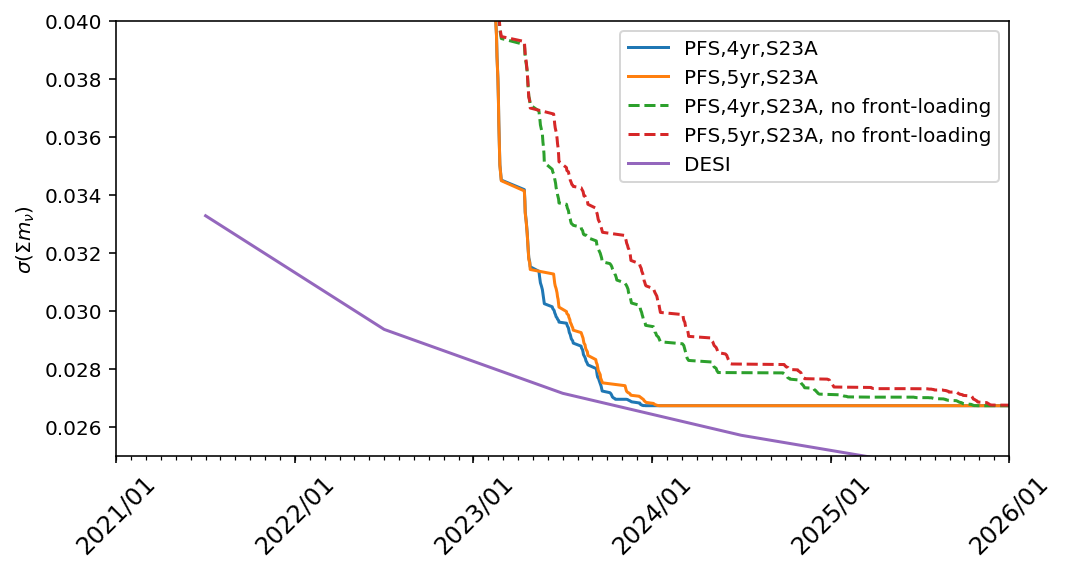

In [152]:
fig,ax = plt.subplots(figsize=(8,4))

# mnu threshold
plt.plot([2020,2027],[0.02,0.02],'k--')

# PFS
# # for S22B case
# model_name_arr = ['/pfs_survey_co_area_completeness_idl_4yr_360nights_co+ga_dwarfs+ge_hscd2_pri.dat',\
#                   '/pfs_survey_co_area_completeness_idl_5yr_360nights_co+ga_dwarfs+ge_hscd2_pri.dat',\
#                   '/pfs_survey_co_area_completeness_idl_4yr_360nights.dat',\
#                   '/pfs_survey_co_area_completeness_idl_5yr_360nights.dat']
# label_arr = ['PFS,4yr,S22B','PFS,5yr,S22B','PFS,4yr,S22B, no front-loading','PFS,5yr,S22B, no front-loading']

# for S23A case
model_name_arr = ['/pfs_survey_co_area_completeness_s23a_idl_4yr_360nights_co+ga_dwarfs+ge_hscd2_pri.dat',\
                  '/pfs_survey_co_area_completeness_s23a_idl_5yr_360nights_co+ga_dwarfs+ge_hscd2_pri.dat',\
                  '/pfs_survey_co_area_completeness_s23a_idl_4yr_360nights.dat',\
                  '/pfs_survey_co_area_completeness_s23a_idl_5yr_360nights.dat']
label_arr = ['PFS,4yr,S23A','PFS,5yr,S23A','PFS,4yr,S23A, no front-loading','PFS,5yr,S23A, no front-loading']

for i in range(4):
    pfs_comp = np.loadtxt(YABESIMDIR+model_name_arr[i])
    if i < 2:
        plt.plot(pfs_comp[:,0],pfs(pfs_comp[:,1]),label=label_arr[i])
    else:
        plt.plot(pfs_comp[:,0],pfs(pfs_comp[:,1]),'--',label=label_arr[i])

# DESI
desi_s = 2021.500 # DESI 1st yr
desi_arr = np.array([desi_s+1.000*i for i in range(5)])
plt.plot(desi_arr,desi[:,1],label='DESI')


# set ticks and labels
ticks = (2020,2021,2022,2023,2024,2025,2026)
ax.set_xticks(np.linspace(2020,2027,8),minor=False)
ax.set_xticks(np.linspace(2020,2027,85),minor=True)
labels = ('2020/01','2021/01','2022/01','2023/01','2024/01','2025/01','2026/01','2027/01')
ax.set_xticklabels(labels,fontsize=12,rotation=45)
ax.set_xticklabels(labels,minor=False)
ax.set_xticklabels([''],minor=True)
ax.set_ylabel(r'$\sigma(\Sigma m_\nu)$')

# set plot rangge
ax.set_xlim((2021,2026))
# ax.set_ylim((0.017,0.025))
# ax.set_ylim((0.017,0.05))
ax.set_ylim((0.025,0.04))

ax.legend()

plt.savefig('./pfs_vs_desi_S23A.pdf')